# PyTorch Introduction

PyTorch is a python library which supports automatic differentiations,
neural network modules, optimizer, and lots of utilities for neural network training and inference.

In this lecture, you will learn how to use pytorch, specifically:

1. Basic Modules
2. Gradient Computation
3. Loss Function and Optimizer
4. Using GPU to Accelerate Computations

In this lecture, you need to connect GPU runtime to use GPU!

You can use GPU in Colab with following steps:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Let us check that GPU is correctly assigned in your runtime.

In [1]:
!nvidia-smi

Thu Apr 10 03:27:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
try:
    import os
    from google.colab import drive
    drive.mount("/content/drive")
    os.chdir("/content/drive/MyDrive/lec11")
except Exception as e:
    print(e)

Mounted at /content/drive


## 1. Basic Modules: Linear Layer and MLP

PyTorch provides basic neural network modules and
`nn.Module` API for you which can implement arbitrary neural network structure,
with GPU acceleration, automatic gradient computation, etc.

In this lecture, we will learn how to use predefined components like linear layer
and implement MLP with basic components.

### 1.1. Linear Layer

Linear Layer is already implemented in `torch.nn.Linear`. You can use it immediately.

Input and output signature are as same as `Linear` class we implemented, let's try it!

In [3]:
import torch
import torch.nn as nn

batch_size = 2
input_dim = 64
output_dim = 256

# Random input tensor
x = torch.randn(batch_size, input_dim)

# Compute linear function output
linear = nn.Linear(input_dim, output_dim)
y = linear(x)

print("input size  :", x.shape)
print("output size :", y.shape)

input size  : torch.Size([2, 64])
output size : torch.Size([2, 256])


### 1.2. Activation Functions

Similarly, activation functions are also provided.

There are two methods to use pytorch's activations functions.

First is the Module API. Activation functions are implemented in the form of
pytorch module, in `torch.nn`, like `relu_module = nn.ReLU()`

Second is the functional API. Activation functions are implemeted in the form of
pure function, in `torch.nn.functional`.

You can use relu function like `y = torch.nn.functional.relu(x)`.

Now let's try to use activation functions!

In [4]:
x = torch.randn(5)

# Module API
relu_module = nn.ReLU()
relu_1 = relu_module(x)

# Functional API
from torch.nn import functional as F
relu_2 = F.relu(x)

print("ReLU input:", x)
print("ReLU output:", relu_1)
assert torch.all(relu_1 >= 0)
assert torch.all(relu_2 >= 0)
assert torch.allclose(relu_1, relu_2)

ReLU input: tensor([-0.1399, -0.9510,  1.5894,  1.2516, -1.2096])
ReLU output: tensor([0.0000, 0.0000, 1.5894, 1.2516, 0.0000])


### 1.3. Module API

Module API is an API for building composite neural networks like MLP or Transformers you build through the lecture.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `MLP`.

2. In the constructor `__init__()`, call `super().__init__()` first and then define module components as class variables, like `self.layer1 = nn.Linear(128, 128)`.

3. Define `forward` method. Model forward computations are made in `forward` method. You need not to implement `__call__` method. `nn.Module`'s `__call__` method automatically calls `forward` method you implemented.

Let's build a simple 3-layer MLP with SiLU activations!

In [5]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.w3 = nn.Linear(hidden_dim, dim)
        self.act_fn = nn.SiLU()

    def forward(self, x):
        h = self.w1(x)
        h = self.act_fn(h)
        h = self.w2(h)
        h = self.act_fn(h)
        output = self.w3(h)
        return output

Let's check inputs and outputs of MLP.

In [6]:
batch_size = 2
input_dim = 32
hidden_dim = 256

x = torch.randn(batch_size, input_dim)
mlp = MLP(input_dim, hidden_dim)
y = mlp(x) # nn.Module's __call__ method calls forward method you implemented.
print("Model input shape:", x.shape)
print("Model output shape:", y.shape)
print("Model output:", y)

Model input shape: torch.Size([2, 32])
Model output shape: torch.Size([2, 32])
Model output: tensor([[ 0.0624, -0.0037,  0.1279,  0.0075, -0.0183,  0.0066, -0.0053,  0.0772,
         -0.0222,  0.0791, -0.0149, -0.0227, -0.0526,  0.1297, -0.0364,  0.0009,
         -0.0178,  0.0126, -0.0609,  0.0983, -0.0075, -0.0475,  0.0440, -0.0021,
         -0.0214,  0.0980,  0.0586,  0.0699, -0.0894,  0.0594,  0.0802, -0.0098],
        [ 0.1862,  0.0208,  0.0102,  0.0319, -0.0604,  0.1983,  0.1065,  0.1738,
         -0.0767,  0.1423, -0.0968, -0.0714, -0.1037,  0.1474,  0.0190, -0.0842,
         -0.1131,  0.0069,  0.0301,  0.0504,  0.0435, -0.0721,  0.0086, -0.0280,
          0.1200, -0.0714,  0.2713,  0.0283,  0.0767,  0.0525,  0.0580, -0.0151]],
       grad_fn=<AddmmBackward0>)


### 1.4. Saving and Loading Model Weights

After successfully training your neural network, you’ll often want to save the model to reuse it later without retraining.

You can retrieve the model parameters as a dictionary using:  
`weights = model.state_dict()`

To save the model parameters to a file, use:  
`torch.save(weights, "path/to/save")`

To load the saved model parameters into a model, use:  
`model.load_state_dict(torch.load("path/to/save"))`

In [7]:
from rich.pretty import pprint
import rich
# save model parameters
weights = mlp.state_dict()
print("Model weights")
print("Dictionary keys:", weights.keys())
for k, v in weights.items():
    pprint(f"{k}: {v}")

torch.save(weights, "checkpoint.pt")

# instantiate new mlp and load saved parameters
new_mlp = MLP(input_dim, hidden_dim)
weights = torch.load("checkpoint.pt")
new_mlp.load_state_dict(weights)

# check whether two models are same
x = torch.randn(batch_size, input_dim)
y1 = mlp(x)
y2 = new_mlp(x)
assert torch.allclose(y1, y2)

Model weights
Dictionary keys: odict_keys(['w1.weight', 'w1.bias', 'w2.weight', 'w2.bias', 'w3.weight', 'w3.bias'])


'w1.weight: tensor([[-0.1204,  0.1381,  0.0238,  ...,  0.1394, -0.0574, -0.0267],\n        [-0.1462,  0.1611, -0.1657,  ..., -0.1083,  0.1329, -0.1541],\n        [-0.0188,  0.0316, -0.1230,  ...,  0.1450, -0.1167, -0.0532],\n        ...,\n        [-0.0532, -0.1025,  0.0847,  ...,  0.1066,  0.1347,  0.0007],\n        [-0.0863, -0.0895, -0.1295,  ..., -0.0770,  0.1286, -0.1480],\n        [ 0.0865, -0.1027,  0.0848,  ..., -0.0281, -0.0367, -0.0719]])'

'w1.bias: tensor([ 0.1346, -0.1537, -0.0349, -0.1566,  0.0923, -0.0721,  0.1602, -0.0924,\n         0.0254,  0.1098, -0.0729, -0.0872, -0.0693,  0.0407,  0.0707,  0.0393,\n         0.0853,  0.1372,  0.0782, -0.0852,  0.0384, -0.1367,  0.1519, -0.0795,\n        -0.1651,  0.0726,  0.0526, -0.0092, -0.0388,  0.0608, -0.1564,  0.0360,\n         0.0636, -0.1746, -0.0568,  0.1499, -0.1527, -0.1126,  0.1485,  0.0467,\n         0.0821, -0.0060, -0.0035, -0.1681,  0.0729, -0.0129,  0.0998,  0.1398,\n        -0.0685,  0.1352,  0.1034,  0.1371,  0.0698,  0.0506, -0.0876, -0.1618,\n         0.0859,  0.0009,  0.1222,  0.1654,  0.1194, -0.0057,  0.1341,  0.0054,\n        -0.1328, -0.0446, -0.1737,  0.0316,  0.0442, -0.1576, -0.1374, -0.0028,\n        -0.0236, -0.1116, -0.1061, -0.0320,  0.1600,  0.1075,  0.0733, -0.1622,\n         0.1273, -0.1452, -0.1564, -0.1387,  0.0787,  0.1734, -0.1388, -0.0604,\n         0.1060,  0.0440, -0.0501,  0.1497, -0.0236,  0.0582, -0.0669, -0.1601,\n        -0.1016,  0.0737, -0.1677, -0.0820,  0.0120, -0.0744,  0.0131,  0.1666,\n        -0.0089,  0.1184, -0.0186, -0.0120,  0.0825,  0.0062,  0.0592,  0.1588,\n         0.0727, -0.0434,  0.1354, -0.0078,  0.0864,  0.1766, -0.1309, -0.0411,\n        -0.1126,  0.1479, -0.0278, -0.1118,  0.1555, -0.1048,  0.0183, -0.1367,\n         0.1390, -0.0908,  0.0038, -0.0348, -0.1222,  0.0867,  0.1600,  0.0556,\n         0.1158, -0.0106, -0.0758,  0.0543,  0.0824,  0.1254,  0.0265, -0.1363,\n         0.0902, -0.1685,  0.1623,  0.1440, -0.0208, -0.0753,  0.0359,  0.1377,\n         0.0341, -0.0117, -0.0808,  0.0485,  0.1491, -0.0729, -0.1403,  0.0575,\n        -0.1313,  0.0612,  0.1109,  0.1766, -0.0090,  0.1599, -0.0794,  0.0475,\n        -0.1032,  0.0455,  0.0613, -0.1102,  0.0320,  0.0753,  0.0320, -0.1174,\n        -0.1301,  0.0287, -0.0893,  0.1689, -0.0514,  0.1475, -0.1614,  0.1596,\n         0.0977,  0.0465,  0.1322, -0.1687, -0.1562,  0.0441, -0.1485, -0.0567,\n         0.1586,  0.1532, -0.1687,  0.0915,  0.1388,  0.0551,  0.1610, -0.1721,\n         0.1160,  0.0391,  0.0877, -0.1610,  0.0486, -0.0816,  0.0405,  0.1029,\n         0.1083,  0.1715, -0.0468,  0.0660,  0.1113, -0.1722,  0.1665,  0.0364,\n         0.0087,  0.1534,  0.1747,  0.1544,  0.0491,  0.0438,  0.1158, -0.0554,\n        -0.1621,  0.1583,  0.1439,  0.0531,  0.1166, -0.1721,  0.1342, -0.0763,\n        -0.1496, -0.0450,  0.1062, -0.0900, -0.0486,  0.0769, -0.0575, -0.0243,\n         0.0418,  0.0874,  0.0071, -0.0647, -0.1649, -0.0409, -0.1687,  0.1755,\n         0.1673,  0.1470,  0.0450, -0.1412,  0.0909,  0.1550, -0.0698, -0.0007])'

'w2.weight: tensor([[ 0.0438,  0.0364,  0.0441,  ...,  0.0346,  0.0507,  0.0561],\n        [-0.0216,  0.0092, -0.0118,  ...,  0.0458,  0.0525,  0.0244],\n        [-0.0121,  0.0167,  0.0337,  ...,  0.0463, -0.0039,  0.0536],\n        ...,\n        [-0.0276, -0.0275, -0.0196,  ...,  0.0163, -0.0383, -0.0183],\n        [-0.0488, -0.0274,  0.0090,  ..., -0.0004,  0.0624, -0.0149],\n        [ 0.0026,  0.0318,  0.0312,  ...,  0.0026,  0.0466,  0.0482]])'

'w2.bias: tensor([ 4.2636e-02,  3.0456e-02, -1.4443e-02, -3.6649e-02,  2.4223e-02,\n        -3.0502e-02,  4.6696e-02, -2.9896e-02,  4.6121e-02,  3.8625e-02,\n        -2.6638e-02, -1.5437e-02,  3.3019e-04, -1.8806e-02,  1.6053e-02,\n        -4.5989e-03, -2.4246e-02, -5.7776e-02,  4.5649e-02, -3.4453e-02,\n        -2.6144e-02,  3.6898e-02, -1.0815e-02, -6.0452e-02, -6.2050e-02,\n         3.5479e-02, -3.7450e-02,  5.8249e-02,  4.3871e-02,  4.6909e-02,\n        -3.1736e-02,  3.2259e-03, -3.4520e-02, -4.5041e-03, -9.4481e-05,\n         5.7866e-03,  3.8827e-02,  3.4756e-02, -4.5551e-02,  5.6852e-02,\n         5.6223e-02, -4.4694e-02, -5.0783e-02, -1.6507e-02,  1.8101e-02,\n         2.3488e-02, -7.9444e-03,  5.4260e-04, -5.6013e-02, -5.7220e-02,\n         1.5483e-02, -3.8156e-02, -2.2233e-02, -4.0315e-02,  3.8823e-02,\n         3.4066e-02, -6.0520e-02, -4.3167e-03, -8.8990e-04,  2.7777e-02,\n         3.9583e-02,  4.8191e-02,  5.6895e-02,  1.1881e-02, -3.5292e-02,\n         6.7885e-03, -1.2829e-02, -1.7619e-02,  1.8699e-03, -3.3268e-02,\n        -6.0041e-02,  4.0735e-02, -6.1690e-02, -5.2165e-02, -3.0991e-02,\n         2.3787e-02, -5.0938e-02, -5.2715e-02,  4.1231e-02, -1.2498e-03,\n         5.8918e-02, -2.3362e-02, -4.1515e-02, -4.5104e-03, -3.0678e-02,\n         4.3221e-02, -2.7284e-02, -3.8030e-02,  6.4930e-03,  2.2351e-02,\n        -5.5177e-02,  1.9746e-03,  1.4805e-02, -9.7592e-03, -3.9952e-02,\n        -4.2989e-02, -4.3421e-02,  1.0974e-02, -4.7025e-02,  2.8833e-02,\n         6.2442e-02,  3.1199e-02,  5.7418e-02, -3.1578e-02,  3.0981e-02,\n        -8.6438e-03,  2.6546e-02,  1.4749e-02,  1.3808e-02, -3.3962e-02,\n         1.2906e-03, -4.6643e-02,  3.0966e-02, -1.3722e-02,  4.2830e-03,\n        -3.5050e-02, -2.0625e-02,  2.8468e-02,  3.5267e-02, -1.0821e-02,\n        -5.5066e-02, -6.1377e-02,  2.9542e-02,  4.3449e-02,  2.4802e-02,\n        -4.5823e-02, -8.9531e-03,  5.1195e-02,  5.7377e-02,  2.3511e-02,\n         6.1417e-02, -1.1426e-02,  5.0726e-02, -4.2324e-02,  5.9051e-02,\n        -5.4125e-02,  5.4690e-02, -3.2435e-02,  1.7503e-02,  5.2313e-02,\n        -3.8160e-02, -4.7360e-02, -4.4186e-02, -2.7790e-02, -5.8349e-02,\n        -6.8459e-03, -1.9469e-02, -1.9250e-02,  2.5568e-03,  5.2766e-02,\n         2.8408e-02, -3.6104e-02,  1.4217e-02, -3.3665e-02,  2.0910e-02,\n         4.8888e-02, -1.1644e-02,  6.1596e-02, -3.2536e-02,  4.3910e-02,\n        -4.9476e-04, -5.4926e-02, -5.5751e-03, -5.4601e-02,  2.7439e-02,\n        -3.1781e-02,  2.2717e-02,  6.1859e-02, -3.8446e-02,  1.9656e-02,\n        -2.7840e-02,  9.9680e-03, -3.4484e-02,  5.8517e-02,  5.0474e-02,\n         4.3394e-02,  2.0292e-02, -5.4274e-02, -2.8349e-02, -5.1582e-03,\n        -5.5683e-02, -3.2375e-02, -5.5646e-02,  4.8157e-02, -4.5297e-02,\n        -1.3267e-02,  4.2170e-02, -1.9579e-02, -7.5294e-03,  4.4454e-02,\n         6.2088e-02,  3.1170e-02,  8.5797e-03,  3.3510e-02,  5.0661e-02,\n         8.0104e-03,  1.5879e-02,  1.0965e-03, -1.6129e-02, -8.6405e-03,\n         1.8070e-02,  3.1471e-02,  3.4660e-02,  2.6514e-02, -6.2493e-02,\n        -7.0171e-03, -6.1576e-02, -3.9932e-02,  2.3051e-02,  2.3486e-02,\n         2.8259e-02, -3.4506e-02, -5.2031e-02, -4.5049e-02,  5.6914e-02,\n         2.8216e-02, -1.7230e-02,  4.8593e-02, -2.0918e-02, -3.7328e-02,\n        -1.9564e-02, -2.3109e-02, -9.1712e-03,  2.4983e-02,  4.1616e-02,\n        -2.1365e-02,  3.0845e-02,  1.0995e-02, -2.4907e-02, -3.8547e-02,\n        -1.3158e-02,  2.8690e-02,  5.3919e-02, -6.1543e-02, -5.4920e-02,\n         5.1192e-02, -1.9879e-02,  1.6987e-02,  6.1204e-02,  3.9311e-02,\n        -4.1950e-03, -1.8730e-02,  2.1243e-02,  1.1203e-02, -2.3000e-02,\n        -5.5190e-02, -2.7049e-02, -3.6665e-02, -3.5675e-02, -2.2654e-02,\n         5.2004e-02, -5.9548e-02,  6.2122e-02,  3.6209e-02, -1.6455e-02,\n        -2.8302e-02])'

'w3.weight: tensor([[-0.0561, -0.0259, -0.0541,  ..., -0.0591,  0.0441, -0.0185],\n        [ 0.0434, -0.0593, -0.0094,  ...,  0.0615,  0.0499,  0.0617],\n        [ 0.0547, -0.0414,  0.0198,  ..., -0.0147, -0.0496, -0.0001],\n        ...,\n        [ 0.0612, -0.0208,  0.0115,  ...,  0.0135,  0.0541, -0.0030],\n        [ 0.0609,  0.0381,  0.0365,  ...,  0.0424, -0.0180, -0.0308],\n        [ 0.0509, -0.0526, -0.0344,  ..., -0.0504, -0.0456,  0.0077]])'

'w3.bias: tensor([ 0.0478,  0.0207,  0.0343,  0.0540, -0.0602,  0.0407, -0.0195,  0.0559,\n        -0.0490, -0.0004, -0.0436, -0.0140, -0.0126,  0.0496,  0.0354,  0.0208,\n        -0.0336,  0.0284,  0.0099,  0.0338,  0.0544, -0.0493,  0.0259,  0.0072,\n         0.0524,  0.0600,  0.0170,  0.0012, -0.0177,  0.0610,  0.0105, -0.0354])'

## 2. Automatic Differentiation

You can compute gradient automatically using pytorch's `backward` method.

You need three steps:

1. Prepare tensors which is tracked by pytorch.
2. Compute scalar(leaf) tensor that you want to differentiate.
3. Call `backward` function.
4. Computed gradient is saved to tensor's `.grad` variable.

Here's an example:

Let $f(x) = \sum_{i=1}^{n} x_i^2$, then $\nabla f(x) = 2x$.
Let's compute this gradient with pytorch and verify it!

In [10]:
# Create tensor that is tracked by pytorch autograd engine.
# default is requires_grad=False.
x = torch.randn(10, requires_grad=True)

# Compute leaf tensor.
y = (x ** 2).sum()

# Call backward function.
y.backward()

# Check gradient.
print("leaf tensor:", y) # you can see that y has grad_fn property
print("gradient:", x.grad)
print("d/dx (x**2) == 2 * x:", torch.allclose(x.grad, 2 * x)) # Check that d/dx (x**2) = 2 * x

leaf tensor: tensor(10.2607, grad_fn=<SumBackward0>)
gradient: tensor([-0.3205,  3.2783,  0.8499,  3.9227, -0.9975,  1.1988, -0.4962,  2.6967,
         1.7893, -0.9648])
d/dx (x**2) == 2 * x: True


## 3. Optimizer and Loss Function

PyTorch provides a variety of optimizers in the `torch.optim` module, including **SGD**, **RMSProp**, and **Adam**.

Optimizers take the model's *learnable parameters* (i.e., parameters with `requires_grad=True`) as input. You can retrieve these by calling `model.parameters()`.

PyTorch also includes several commonly used loss functions in the `torch.nn` module, such as **Mean Squared Error (MSE)** and **Cross Entropy**, e.g., `nn.MSELoss`.

Similar to activation functions, PyTorch allows you to use the functional API for computing loss directly, such as `loss = F.mse_loss(x, y)`.

To use an optimizer, follow these general steps:

1. Initialize the optimizer
   ```python
   optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
   ```

2. Compute the loss
   ```python
   loss = F.mse_loss(output, target)
   ```

3. Clear previously accumulated gradients  
   ```python
   optimizer.zero_grad()
   ```  
   If you skip this step, gradients will be accumulated each time you call `loss.backward()`.

4. Compute the gradient using backpropagation.
   ```python
   loss.backward()
   ```

5. Update the parameters
   ```python
   optimizer.step()
   ```  
   This performs a single optimization step using the computed gradients.



Let us train our MLP to fit the sine function $y = \sin(x)$ with Adam Optimizer!

In [11]:
from torch import optim

# MLP with input and output dimension is 1
mlp = MLP(1, 128)

# Prepare training data
x = torch.randn(100, 1)
y = torch.sin(2 * torch.pi * x)

# example of model.parameters()
rich.print("Learnable parameter example:\n", next(iter(mlp.parameters())).squeeze())

# 1. Initialize Optimizer.
optimizer = optim.Adam(mlp.parameters())

losses = []
for step in range(1000):
    y_pred = mlp(x)
    loss = F.mse_loss(y_pred, y) # 2. compute loss function
    optimizer.zero_grad() # 3. clear previous computed gradient
    loss.backward() # 4. compute gradient for current loss function
    optimizer.step() # 5. do single update step

    losses.append(loss.item())

    if (step + 1) % 100 == 0:
        print("{:4d}/{}: loss = {:.6f}".format(step + 1, 1000, loss.item()))


Learnable parameter example:
 tensor([ 0.0378,  0.5053, -0.8621, -0.2767, -0.0636,  0.9963, -0.9394, -0.6465,
         0.1355,  0.0771,  0.7318, -0.6611,  0.3470, -0.1156,  0.1400,  0.6411,
        -0.8691, -0.3220, -0.1114, -0.4760, -0.9305,  0.9258, -0.1794,  0.9622,
         0.7438, -0.1845,  0.3535,  0.3241,  0.4489,  0.4364, -0.3499, -0.8078,
        -0.4496,  0.8393,  0.8213, -0.4303, -0.0957,  0.8873,  0.6173,  0.4645,
         0.8072,  0.8083,  0.6925,  0.4414, -0.8779,  0.4588, -0.5960,  0.8457,
        -0.4361,  0.7791,  0.6461,  0.3767,  0.2791, -0.6718,  0.1755, -0.4562,
        -0.9450, -0.1320,  0.4177,  0.2740,  0.5302,  0.6003, -0.8880, -0.3652,
        -0.8846, -0.4832, -0.6310,  0.7475,  0.9546, -0.4833,  0.1073,  0.1560,
        -0.5605,  0.1874, -0.0922,  0.0455,  0.6309, -0.4721,  0.1272, -0.1663,
        -0.9459,  0.7198, -0.2324,  0.3523, -0.7915,  0.5970,  0.3822, -0.5379,
         0.5013,  0.2357, -0.6205,  0.1814, -0.2686, -0.8549, -0.6472,  0.1516,
         0.5678, -0.4535,  0.7484,  0.4303, -0.2320,  0.8375, -0.7091, -0.8657,
        -0.9514, -0.7597, -0.3325,  0.0460, -0.0371, -0.0757,  0.5481,  0.3919,
         0.7667,  0.8141,  0.9669,  0.6229,  0.6665, -0.5568,  0.7324,  0.0999,
         0.5407, -0.9063, -0.3395, -0.6571,  0.2915,  0.1545, -0.0715,  0.9554],
       grad_fn=<SqueezeBackward0>)

 100/1000: loss = 0.509948
 200/1000: loss = 0.466546
 300/1000: loss = 0.116044
 400/1000: loss = 0.010211
 500/1000: loss = 0.005492
 600/1000: loss = 0.003877
 700/1000: loss = 0.002719
 800/1000: loss = 0.002218
 900/1000: loss = 0.002017
1000/1000: loss = 0.001569


Let's see how the loss is decreased as we update model.

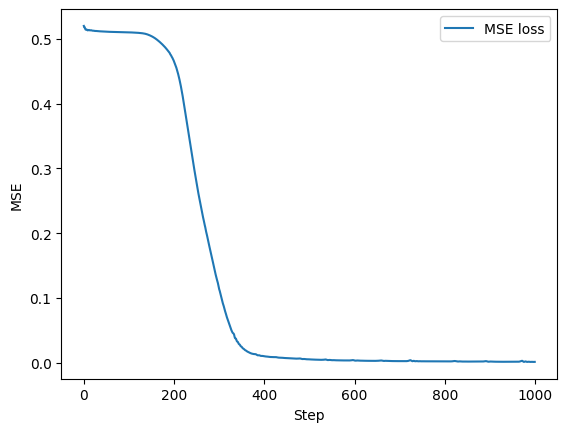

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses, label='MSE loss')
plt.xlabel("Step")
plt.ylabel("MSE")
plt.legend()
plt.show()

Let's check that whether our MLP is well trained!

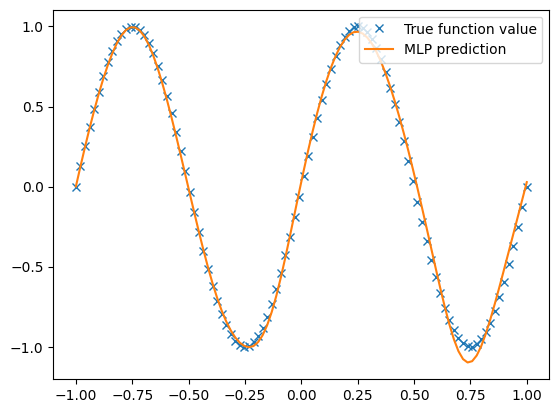

In [13]:
# test input
x = torch.linspace(-1, 1, 100).reshape(-1, 1)

# test output
y = torch.sin(2 * torch.pi * x)

# use this when gradient computation is not needed
with torch.no_grad():
    y_pred = mlp(x)

plt.plot(x, y, 'x', label='True function value')
plt.plot(x, y_pred, label='MLP prediction')
plt.legend(loc='upper right')
plt.show()

## 4. GPU acceleration

PyTorch can easily use NVIDIA GPU to accelerate Neural Network Training and Inference.

First, you can check whether GPU is available by: `torch.cuda.is_available()`.

In pytorch, GPU is handled as a `device` object, like
`torch.device("cuda:0")`.

When you have multiple GPUs, then you can use multiple devices like `torch.device("cuda:1"), torch.device("cuda:2"), ...`

If GPU is available, you should do:

1. create device object `device = torch.device("cuda:0")`
2. send every tensors and models to the GPU using `.to(device)`,
or create tensors directly on GPU memory using `torch.tensor([1,2,3], device=device)`.

Here's an example.

In [14]:
# Check GPU availability
print("GPU availablity:", torch.cuda.is_available())

# Create device object
device = torch.device("cuda:0")


# Send torch tensor to GPU
x = torch.randn(100, 1).to(device)


# Or you can create tensor directly to GPU memory:
x = torch.randn(100, 1, device=device)
print("Device of input:", x.device)

# Note that when you do some computations with tensors on GPU,
# then the output is automatically on GPU.
y = torch.sin(2 * torch.pi * x)

print("Device of output:", y.device)

# Send model(model's parameters) to GPU
mlp = mlp.to(device)
print("Device of model parameter:", mlp.w1.weight.device)

y_pred = mlp(x)

# backpropagation on GPU
loss = (y_pred - y).sum()
loss.backward()

print("Device of model output:", y_pred.device)

GPU availablity: True
Device of input: cuda:0
Device of output: cuda:0
Device of model parameter: cuda:0
Device of model output: cuda:0


Now, let's check that is GPU computation really fast!

We will use this helper function to do the same process twice with different devices.

In [15]:
import random
import numpy as np
def train(x, y, device, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    model = MLP(1, 1024)
    # Prepare loss function
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    ### NEW ###
    x = x.to(device)
    y = y.to(device)
    model = model.to(device)
    ###########

    for step in range(1000):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step + 1) % 100 == 0:
            print("{:4d}/{}: loss = {:.6f}".format(step + 1, 1000, loss.item()))

In [16]:
x = torch.randn(1000, 1)
y = torch.sin(2 * torch.pi * x)

In [17]:
%%time
train(x, y, device=torch.device("cpu"))

 100/1000: loss = 0.488834
 200/1000: loss = 0.488709
 300/1000: loss = 0.488624
 400/1000: loss = 0.456323
 500/1000: loss = 0.100953
 600/1000: loss = 0.042748
 700/1000: loss = 0.032036
 800/1000: loss = 0.025917
 900/1000: loss = 0.021478
1000/1000: loss = 0.018171
CPU times: user 1min 13s, sys: 1.45 s, total: 1min 15s
Wall time: 1min 16s


In [18]:
%%time
train(x, y, device=torch.device("cuda:0"))

 100/1000: loss = 0.488834
 200/1000: loss = 0.488709
 300/1000: loss = 0.488624
 400/1000: loss = 0.456323
 500/1000: loss = 0.097625
 600/1000: loss = 0.041571
 700/1000: loss = 0.032049
 800/1000: loss = 0.025554
 900/1000: loss = 0.020948
1000/1000: loss = 0.017296
CPU times: user 2.18 s, sys: 132 ms, total: 2.31 s
Wall time: 2.52 s
